In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from joblib import Parallel,delayed
from multiprocessing import cpu_count
import pandas as pd
from tqdm.notebook import tqdm
import os
import cmath
import time
import math
import bilby
import tempfile
import h5py
from tkinter import Tcl
import numpy.lib.recfunctions as rfn

from scipy.interpolate import interp1d,RectBivariateSpline
from scipy.integrate import solve_ivp
from scipy.special import factorial2,beta
from scipy.integrate import quad,nquad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,toms748,minimize
import scipy.stats as st
import seaborn as sns

In [2]:
import sys
sys.path.insert(0, '../../')

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing modules from stanspy
from stanspy.GRNS import NSP_Solver,about_stanspy
from stanspy.EOS_manager import Import_EOS
from stanspy.Constants import *

# Additional Tools
from stanspy.mtools import adaptive_gaussian_quadrature,gauss_leg,RK4,Root_Finder
from stanspy.additionals import labelLines,MR_Constraint_Data,MI_constraint_data,mpl_settings,Color_Mapping,End_of_the_program,readDict,writeDict
from stanspy.UR_tools import Best_Fit,data_sorter,range_extractor,arraywise_average,poly_model,Constraining_tool

about_stanspy()
mpl_settings()

mpl.rcParams['lines.markersize'] = 4


★---------------------------------|stanspy|---------------------------------★
stanspy ~ Sailesh's Tools for Analysis of Neutron Star Properties in python
version= 1.4.2 (General Relativistic Neutron Stars | GRNS)
author= Sailesh Ranjan Mohanty
author_email= saileshranjanmohanty@gmail.com
supervisor= Bharat Kumar
★----------------------------------©BKlabs----------------------------------★



# Data Extraction

In [4]:
class Ensemble_Extraction:
    def __init__(self,path):
        self.Ensemble_Data= self.Extraction(path)
        
        Data= dict()
        Data["M"]= []
        Data["R"]= []
        Data["L"]= []
        Data["f"]= []
        Data["t"]= []
        
        self.Data= Data

    def M_extract(self,Mass,M,Ec,*params):
        Mmax= max(M)
        if Mass>Mmax:
            return None
        
        M2Ec= interp1d(M,Ec)
        Ec_at_M= M2Ec(Mass)
        P_at_M= []
        for P in params:
            P_at_M.append(interp1d(Ec,P)(Ec_at_M))
            
        return P_at_M
    
    def Extraction(self,path):

        Data= dict()
        for file in tqdm(Tcl().call('lsort', '-dict', os.listdir(path))):
            if file.endswith(".json"): dat= readDict(path+file)
            else: continue

            Ec_array= dat["Ec"]
            M_array= dat["M"]
            R_array= dat["R"]
            Lamda_array= dat["Lambda"]
            f_array= dat["NRO_GR"]["f"]
            tao_array= dat["NRO_GR"]["DT"]

            if min(tao_array)<0.1 or min(M_array)<0.7:
                continue

            eos= file[:-5]
            Data[eos]= dict()
            Data[eos]["Ec"]= Ec_array
            Data[eos]["M"]= M_array
            Data[eos]["R"]= R_array
            Data[eos]["L"]= Lamda_array
            Data[eos]["f"]= f_array
            Data[eos]["t"]= tao_array

        return Data
    
    def __call__(self,*Mass):
        Data= self.Data
        
        if len(Mass)>=1:
            for m in Mass:
                if m==max:
                    Data["M_max"]= []
                    Data["R_max"]= []
                    Data["L_max"]= []
                    Data["f_max"]= []
                    Data["t_max"]= []
                    continue
                Data["R_%s" %m]= []
                Data["L_%s" %m]= []
                Data["f_%s" %m]= []
                Data["t_%s" %m]= []
        
        for dat in tqdm(self.Ensemble_Data.values()):
            Ec= dat["Ec"]
            M= dat["M"]
            R= dat["R"]
            L= dat["L"]     
            f= dat["f"] 
            t= dat["t"]
                        
            Data["M"].append(M)
            Data["R"].append(R)
            Data["L"].append(L)
            Data["f"].append(f)
            Data["t"].append(t)
            
            if len(Mass)>=1:
                for m in Mass:
                    if m==max:
                        Data["M_max"].append(M[-1])
                        Data["R_max"].append(R[-1])
                        Data["L_max"].append(L[-1])
                        Data["f_max"].append(f[-1])
                        Data["t_max"].append(t[-1])
                        continue
                    p_at_m= self.M_extract(m,M,Ec,R,L,f,t)
                    if p_at_m==None:
                        continue
                    R_m,L_m,f_m,t_m= p_at_m
                    Data["R_%s" %m].append(R_m)
                    Data["L_%s" %m].append(L_m)
                    Data["f_%s" %m].append(f_m)
                    Data["t_%s" %m].append(t_m)
            
        Data["M"]= np.concatenate(Data["M"])
        Data["R"]= np.concatenate(Data["R"])
        Data["L"]= np.concatenate(Data["L"])
        Data["f"]= np.concatenate(Data["f"])
        Data["t"]= np.concatenate(Data["t"]) 

        if len(Mass)>=1:
            for m in Mass:
                if m==max:
                    Data["M_max"]= np.array(Data["M_max"])
                    Data["R_max"]= np.array(Data["R_max"])
                    Data["L_max"]= np.array(Data["L_max"])
                    Data["f_max"]= np.array(Data["f_max"])
                    Data["t_max"]= np.array(Data["t_max"])
                    continue
                Data["R_%s" %m]= np.array(Data["R_%s" %m])
                Data["L_%s" %m]= np.array(Data["L_%s" %m])
                Data["f_%s" %m]= np.array(Data["f_%s" %m])
                Data["t_%s" %m]= np.array(Data["t_%s" %m])
        
        return Data

In [5]:
PSR_class= Ensemble_Extraction("Data/LCEHL_EOS_posterior_samples_PSR/")
GW_class= Ensemble_Extraction("Data/LCEHL_EOS_posterior_samples_PSR+GW/")
NICER_class= Ensemble_Extraction("Data/LCEHL_EOS_posterior_samples_PSR+GW+NICER/")

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

In [45]:
outfile = h5py.File("/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR.h5", 'w')
outfile.close()
outfile = h5py.File("/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR+GW.h5", 'w')
outfile.close()
outfile = h5py.File("/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR+GW+NICER.h5", 'w')
outfile.close()

# PSR

In [46]:
Data= PSR_class.Ensemble_Data
infile = h5py.File("/home/sailesh/GitHub/ns-fmodes/etc/LCEHL_EOS_posterior_samples_PSR.h5", 'r')
outfile = h5py.File("/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR.h5", 'w')

id_list = []
for key in Data.keys():
    i= int(key[4:])
    id_list.append(infile["id"][i])    

id_set = outfile.create_dataset('id',data=np.array(id_list))
eos_set = outfile.create_group('eos')
ns_set = outfile.create_group('ns')

for i,key in enumerate(tqdm(Data.keys())):
    eos= infile["eos"][key]
    eos_data = np.column_stack((eos['pressurec2'],eos['energy_densityc2'],eos['baryon_density']))
    eos_data = rfn.unstructured_to_structured(eos_data, np.dtype([('pressurec2', 'f8'), ('energy_densityc2', 'f8'), ('baryon_density', 'f8')]))
    eos_set.create_dataset("eos_%i" %i,data=eos_data)

    ns= Data[key]
    ns_data = np.array(np.column_stack((ns['Ec']*Mev_per_fm_cube__to__Kg_per_m_3*(1000/(100**3)),ns['M'],ns['R'],ns['L'],ns['f'])))
    ns_data = rfn.unstructured_to_structured(ns_data, np.dtype([('rhoc', 'f8'), ('M', 'f8'), ('R', 'f8'), ('Lambda', 'f8'), ('f', 'f8')]))
    ns_set.create_dataset("eos_%i" %i,data=ns_data)
        
outfile.close()
infile.close()

  0%|          | 0/9835 [00:00<?, ?it/s]

# PSR+GW

In [47]:
Data= PSR_class.Ensemble_Data
infile = h5py.File("/home/sailesh/GitHub/ns-fmodes/etc/LCEHL_EOS_posterior_samples_PSR+GW.h5", 'r')
outfile = h5py.File("/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR+GW.h5", 'w')

id_list = []
for key in Data.keys():
    i= int(key[4:])
    id_list.append(infile["id"][i])    

id_set = outfile.create_dataset('id',data=np.array(id_list))
eos_set = outfile.create_group('eos')
ns_set = outfile.create_group('ns')

for i,key in enumerate(tqdm(Data.keys())):
    eos= infile["eos"][key]
    eos_data = np.column_stack((eos['pressurec2'],eos['energy_densityc2'],eos['baryon_density']))
    eos_data = rfn.unstructured_to_structured(eos_data, np.dtype([('pressurec2', 'f8'), ('energy_densityc2', 'f8'), ('baryon_density', 'f8')]))
    eos_set.create_dataset("eos_%i" %i,data=eos_data)

    ns= Data[key]
    ns_data = np.array(np.column_stack((ns['Ec']*Mev_per_fm_cube__to__Kg_per_m_3*(1000/(100**3)),ns['M'],ns['R'],ns['L'],ns['f'])))
    ns_data = rfn.unstructured_to_structured(ns_data, np.dtype([('rhoc', 'f8'), ('M', 'f8'), ('R', 'f8'), ('Lambda', 'f8'), ('f', 'f8')]))
    ns_set.create_dataset("eos_%i" %i,data=ns_data)
        
outfile.close()
infile.close()

  0%|          | 0/9835 [00:00<?, ?it/s]

# PSR+GW+NICER

In [48]:
Data= PSR_class.Ensemble_Data
infile = h5py.File("/home/sailesh/GitHub/ns-fmodes/etc/LCEHL_EOS_posterior_samples_PSR+GW+NICER.h5", 'r')
outfile = h5py.File("/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR+GW+NICER.h5", 'w')

id_list = []
for key in Data.keys():
    i= int(key[4:])
    id_list.append(infile["id"][i])    

id_set = outfile.create_dataset('id',data=np.array(id_list))
eos_set = outfile.create_group('eos')
ns_set = outfile.create_group('ns')

for i,key in enumerate(tqdm(Data.keys())):
    eos= infile["eos"][key]
    eos_data = np.column_stack((eos['pressurec2'],eos['energy_densityc2'],eos['baryon_density']))
    eos_data = rfn.unstructured_to_structured(eos_data, np.dtype([('pressurec2', 'f8'), ('energy_densityc2', 'f8'), ('baryon_density', 'f8')]))
    eos_set.create_dataset("eos_%i" %i,data=eos_data)

    ns= Data[key]
    ns_data = np.array(np.column_stack((ns['Ec']*Mev_per_fm_cube__to__Kg_per_m_3*(1000/(100**3)),ns['M'],ns['R'],ns['L'],ns['f'])))
    ns_data = rfn.unstructured_to_structured(ns_data, np.dtype([('rhoc', 'f8'), ('M', 'f8'), ('R', 'f8'), ('Lambda', 'f8'), ('f', 'f8')]))
    ns_set.create_dataset("eos_%i" %i,data=ns_data)
        
outfile.close()
infile.close()

  0%|          | 0/9835 [00:00<?, ?it/s]

# Plotting

  0%|          | 0/9835 [00:00<?, ?it/s]

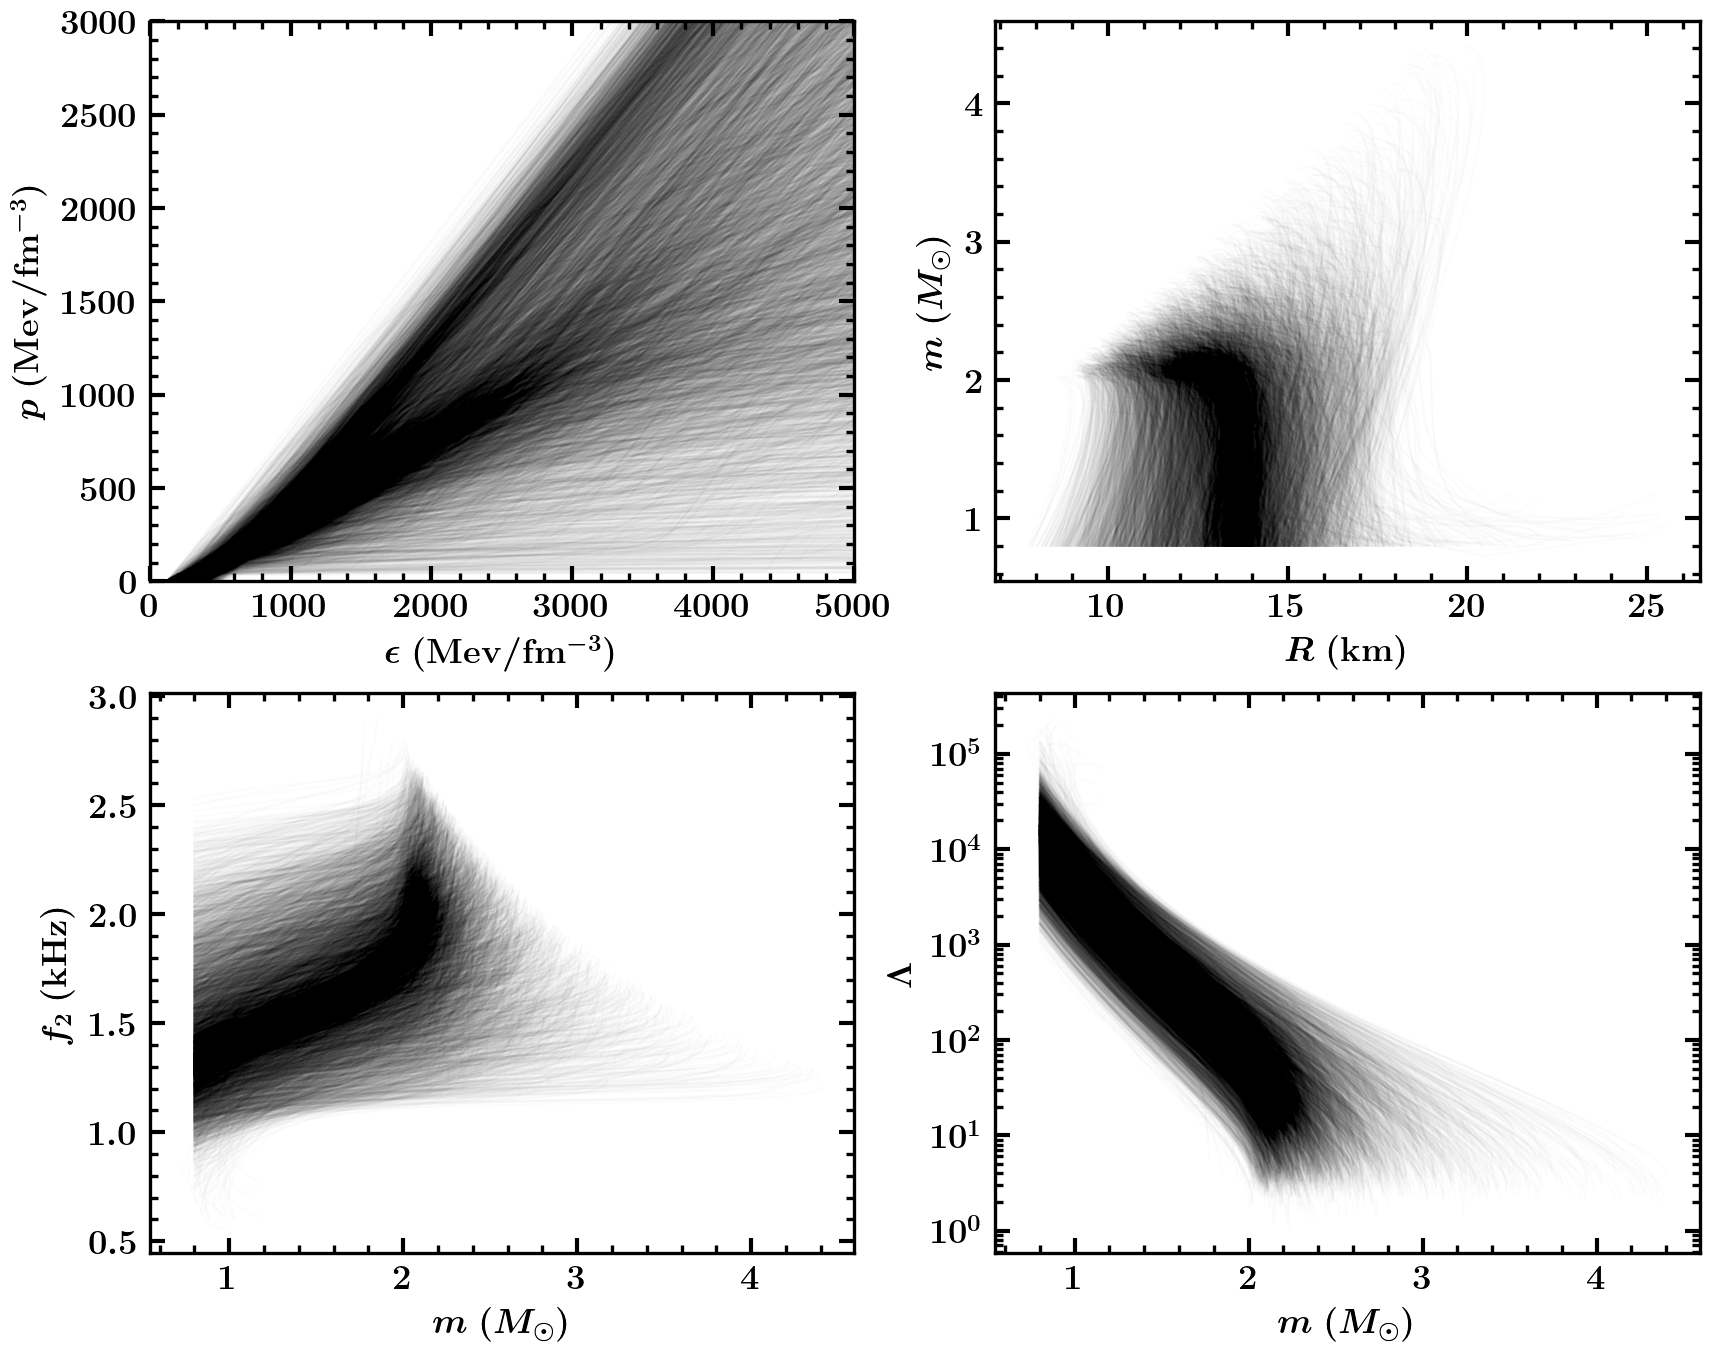

In [50]:
h5path= "/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR.h5"
dat= h5py.File(h5path)

alpha=0.01
n=len(dat["eos"])

fig,ax= plt.subplots(2,2,figsize=(10*2,8*2))

for i in tqdm(range(n)):
    
    e= dat["eos"]["eos_%i" %i]["energy_densityc2"]*1000*Kg__to__m/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square)
    p= dat["eos"]["eos_%i" %i]["pressurec2"]*1000*Kg__to__m/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square)
    
    ax[0,0].plot(e,p,color="k",alpha=alpha)
    
    M= dat["ns"]["eos_%i" %i]["M"]
    R= dat["ns"]["eos_%i" %i]["R"]
    L= dat["ns"]["eos_%i" %i]["Lambda"]
    f= dat["ns"]["eos_%i" %i]["f"]
    
    ax[0,1].plot(R,M,color="k",alpha=alpha)
    ax[1,0].plot(M,f,color="k",alpha=alpha)
    ax[1,1].plot(M,L,color="k",alpha=alpha)

ax[0,0].set_xlim(0,5000)
ax[0,0].set_ylim(0,3000)
ax[1,1].set_yscale("log")

ax[0,0].set_xlabel(r'$\epsilon \ ({\rm Mev/fm^{-3}})$', labelpad= 8)
ax[0,0].set_ylabel(r'$p \ ({\rm Mev/fm^{-3}})$', labelpad= 10)
ax[0,1].set_xlabel(r'$R \ ({\rm km})$', labelpad= 8)
ax[0,1].set_ylabel(r'$m \ (M_\odot)$', labelpad= 10)
ax[1,0].set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax[1,0].set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)
ax[1,1].set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax[1,1].set_ylabel(r"$\Lambda$", labelpad= 10)

plt.show()

  0%|          | 0/9835 [00:00<?, ?it/s]

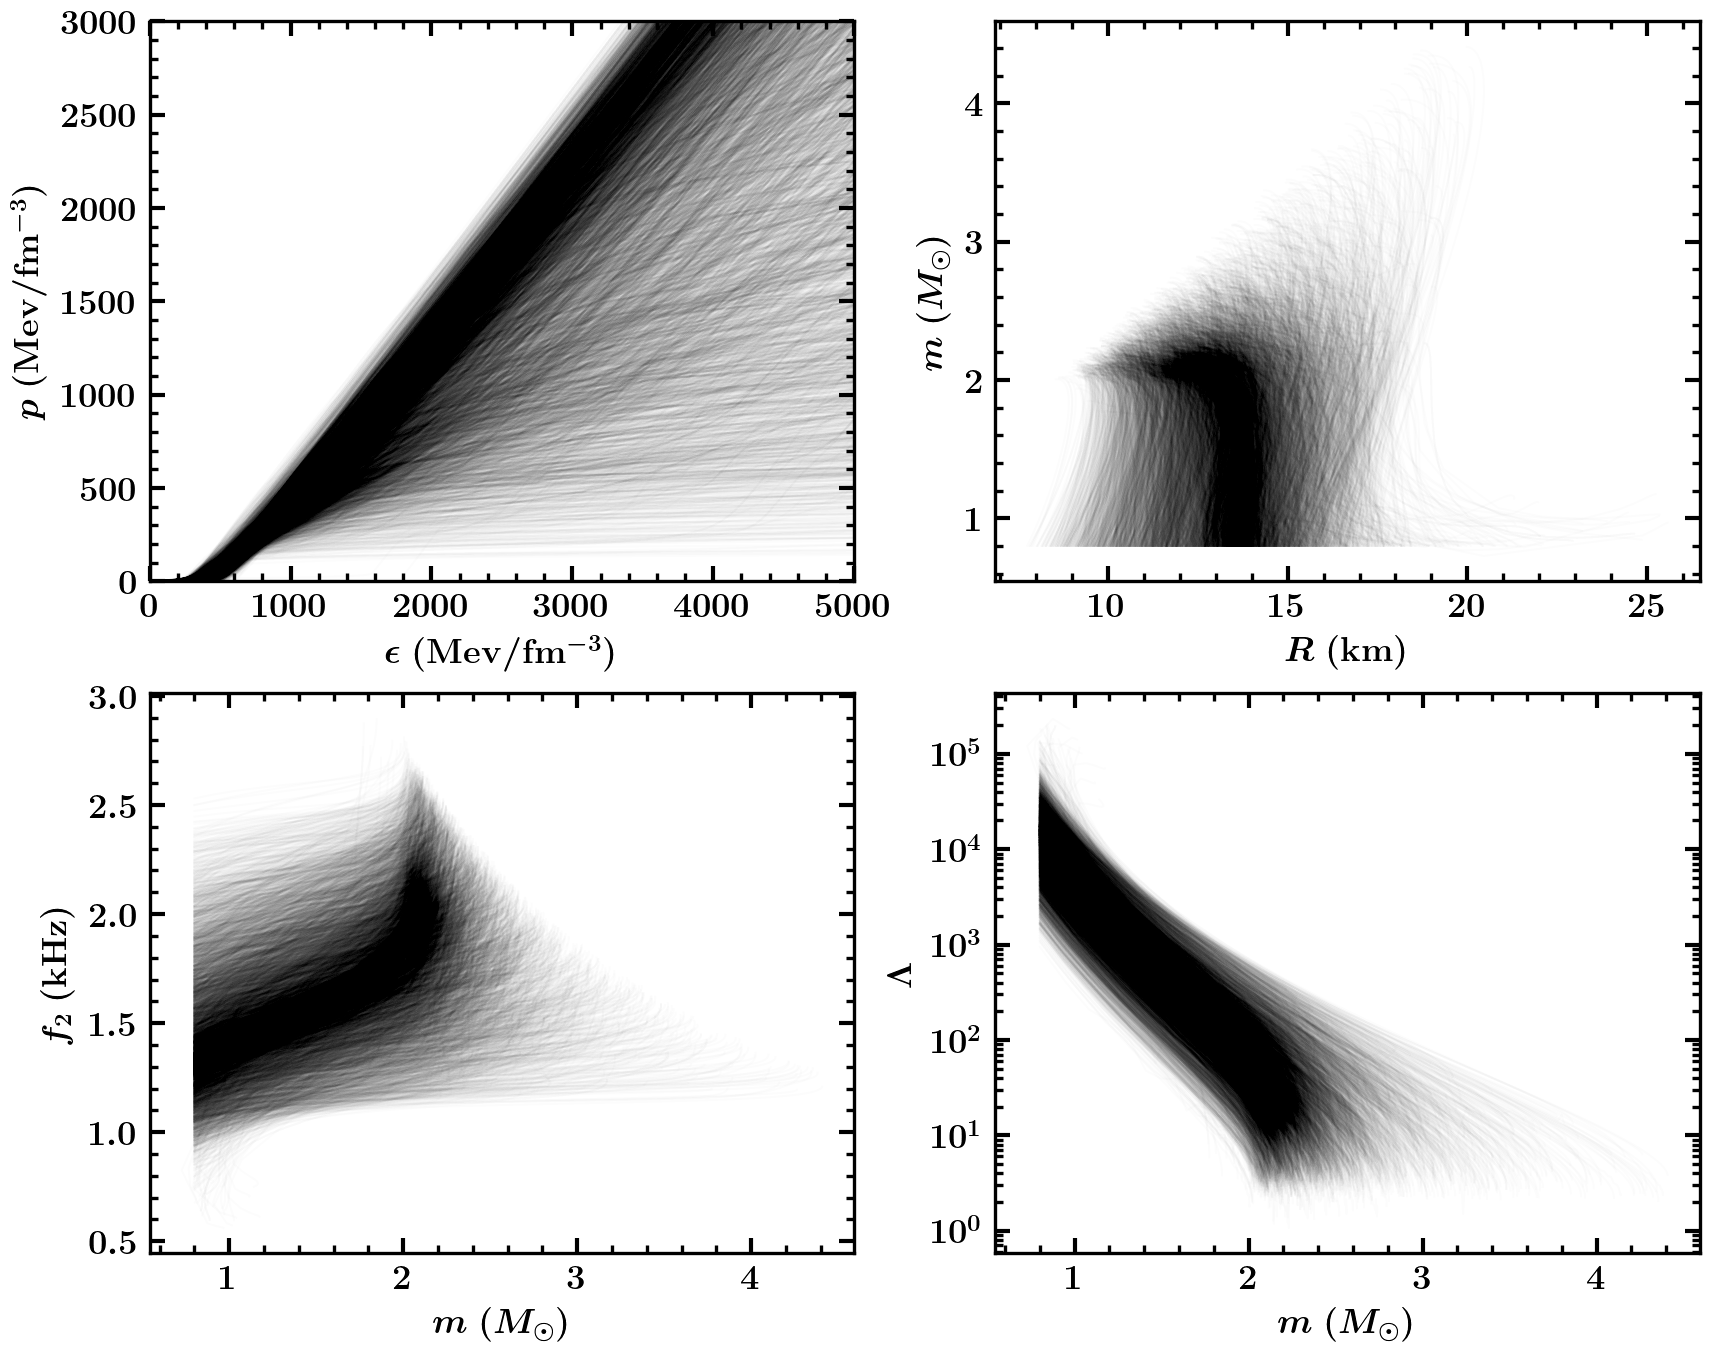

In [51]:
h5path= "/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR+GW.h5"
dat= h5py.File(h5path)

alpha=0.01
n=len(dat["eos"])

fig,ax= plt.subplots(2,2,figsize=(10*2,8*2))

for i in tqdm(range(n)):
    
    e= dat["eos"]["eos_%i" %i]["energy_densityc2"]*1000*Kg__to__m/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square)
    p= dat["eos"]["eos_%i" %i]["pressurec2"]*1000*Kg__to__m/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square)
    
    ax[0,0].plot(e,p,color="k",alpha=alpha)
    
    M= dat["ns"]["eos_%i" %i]["M"]
    R= dat["ns"]["eos_%i" %i]["R"]
    L= dat["ns"]["eos_%i" %i]["Lambda"]
    f= dat["ns"]["eos_%i" %i]["f"]
    
    ax[0,1].plot(R,M,color="k",alpha=alpha)
    ax[1,0].plot(M,f,color="k",alpha=alpha)
    ax[1,1].plot(M,L,color="k",alpha=alpha)

ax[0,0].set_xlim(0,5000)
ax[0,0].set_ylim(0,3000)
ax[1,1].set_yscale("log")

ax[0,0].set_xlabel(r'$\epsilon \ ({\rm Mev/fm^{-3}})$', labelpad= 8)
ax[0,0].set_ylabel(r'$p \ ({\rm Mev/fm^{-3}})$', labelpad= 10)
ax[0,1].set_xlabel(r'$R \ ({\rm km})$', labelpad= 8)
ax[0,1].set_ylabel(r'$m \ (M_\odot)$', labelpad= 10)
ax[1,0].set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax[1,0].set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)
ax[1,1].set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax[1,1].set_ylabel(r"$\Lambda$", labelpad= 10)

plt.show()

  0%|          | 0/9835 [00:00<?, ?it/s]

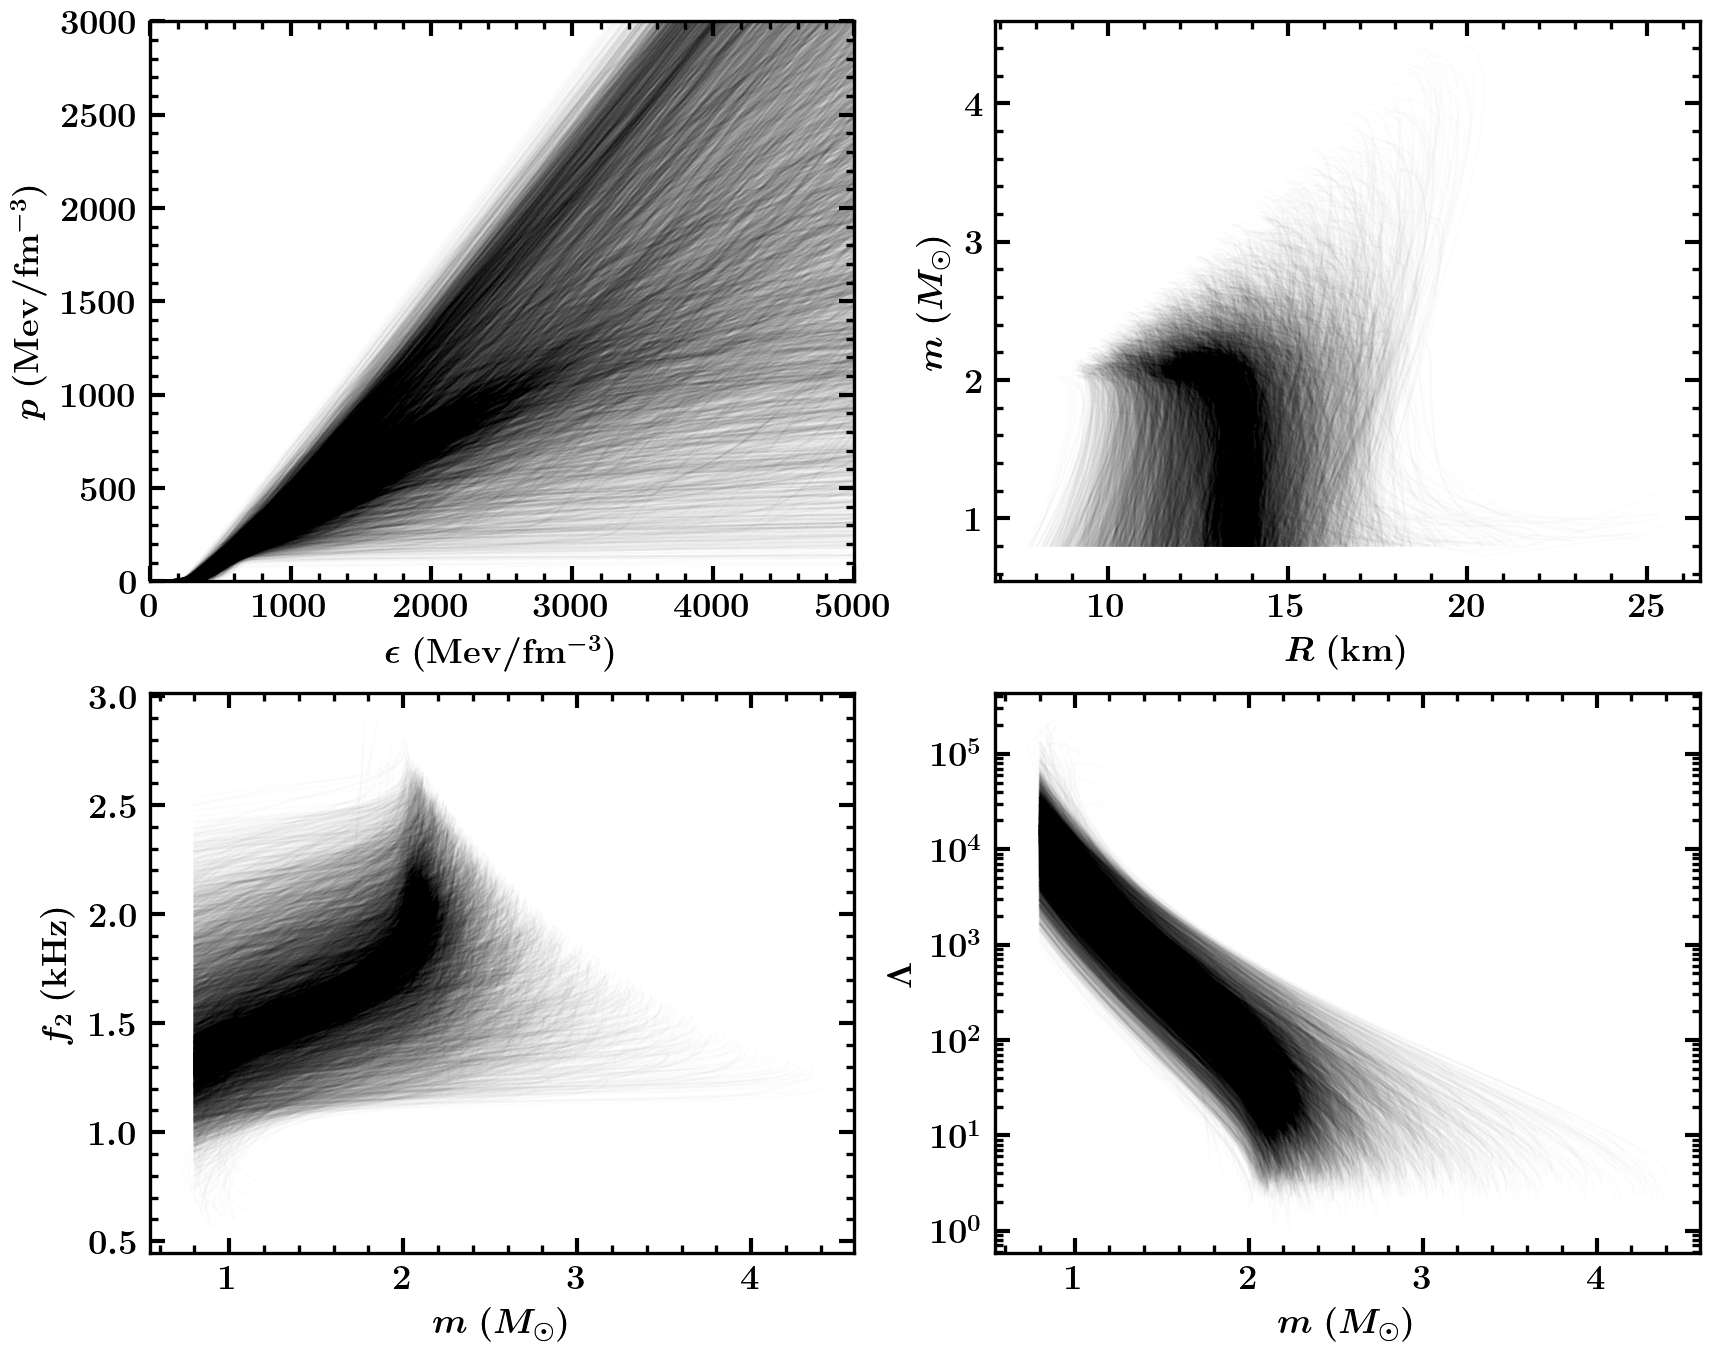

In [52]:
h5path= "/home/sailesh/GitHub/ns-fmodes/Data_File/EoS_posterior_samples_PSR+GW+NICER.h5"
dat= h5py.File(h5path)

alpha=0.01
n=len(dat["eos"])

fig,ax= plt.subplots(2,2,figsize=(10*2,8*2))

for i in tqdm(range(n)):
    
    e= dat["eos"]["eos_%i" %i]["energy_densityc2"]*1000*Kg__to__m/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square)
    p= dat["eos"]["eos_%i" %i]["pressurec2"]*1000*Kg__to__m/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square)
    
    ax[0,0].plot(e,p,color="k",alpha=alpha)
    
    M= dat["ns"]["eos_%i" %i]["M"]
    R= dat["ns"]["eos_%i" %i]["R"]
    L= dat["ns"]["eos_%i" %i]["Lambda"]
    f= dat["ns"]["eos_%i" %i]["f"]
    
    ax[0,1].plot(R,M,color="k",alpha=alpha)
    ax[1,0].plot(M,f,color="k",alpha=alpha)
    ax[1,1].plot(M,L,color="k",alpha=alpha)

ax[0,0].set_xlim(0,5000)
ax[0,0].set_ylim(0,3000)
ax[1,1].set_yscale("log")

ax[0,0].set_xlabel(r'$\epsilon \ ({\rm Mev/fm^{-3}})$', labelpad= 8)
ax[0,0].set_ylabel(r'$p \ ({\rm Mev/fm^{-3}})$', labelpad= 10)
ax[0,1].set_xlabel(r'$R \ ({\rm km})$', labelpad= 8)
ax[0,1].set_ylabel(r'$m \ (M_\odot)$', labelpad= 10)
ax[1,0].set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax[1,0].set_ylabel(r"$f_2 \ \mathrm{(kHz)}$", labelpad= 10)
ax[1,1].set_xlabel(r'$m \ (M_\odot)$', labelpad= 8)
ax[1,1].set_ylabel(r"$\Lambda$", labelpad= 10)

plt.show()